In [7]:
import os
import numpy as np
def get_filelist(home_dir):
    filelist = []
    for dirpath, dirnames, filenames in os.walk(home_dir):
        for filename in filenames:
            fn = os.path.join(dirpath,filename)
            filelist.append(fn)
    filelist = sorted(filelist)
    return filelist



depthlist = get_filelist('cloth2/right/depth')
rgblist = get_filelist('cloth2/right/rgb')

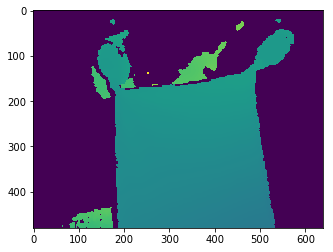

0


In [26]:
import cv2
import matplotlib.pyplot as plt

i = 1
depth = cv2.imread(depthlist[i], cv2.IMREAD_UNCHANGED)
plt.imshow(depth), plt.show()
print np.min(depth)
# histr = cv2.calcHist([depth],[0],None,[80000],[0,2000])
# plt.plot(histr,color = col), plt.show()



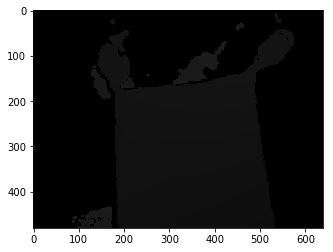

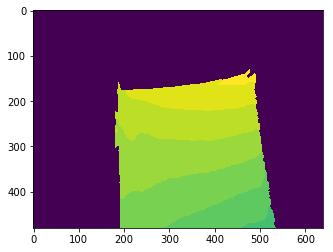

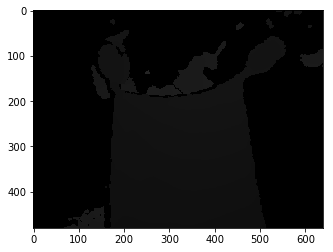

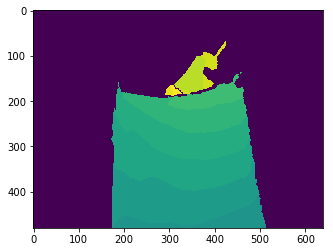

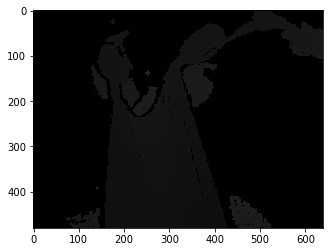

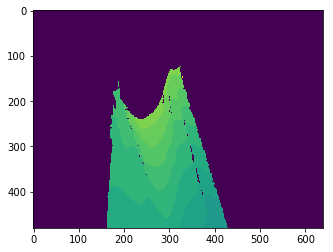

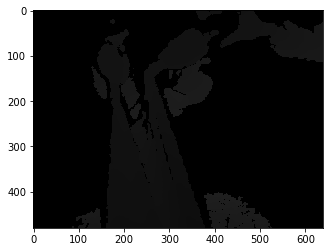

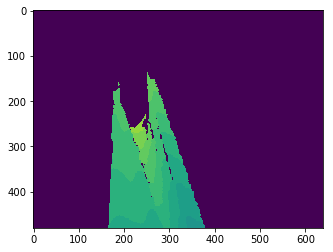

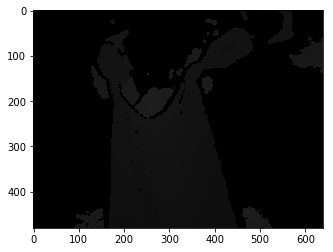

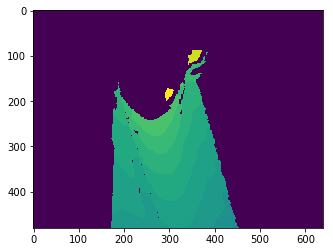

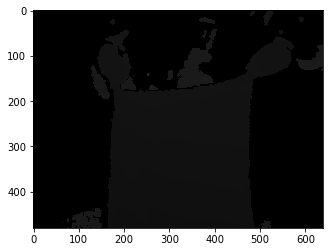

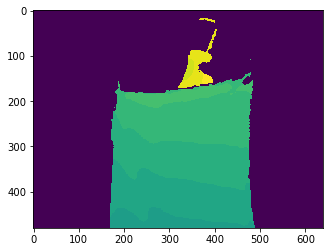

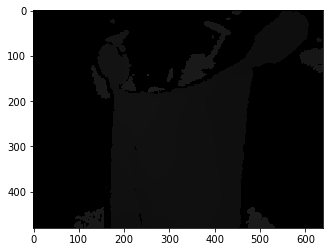

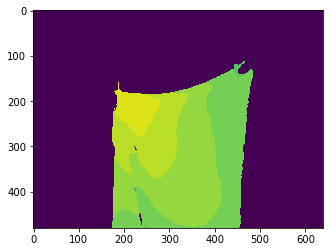

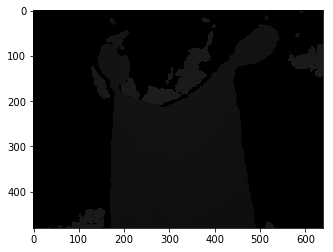

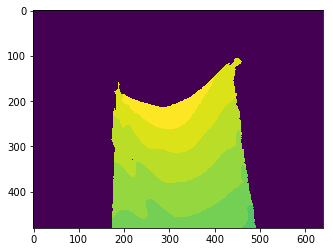

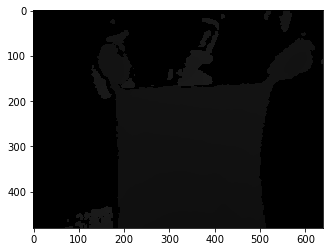

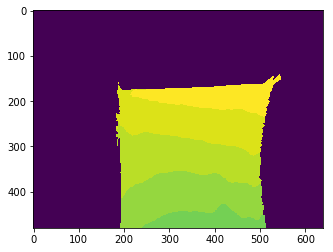

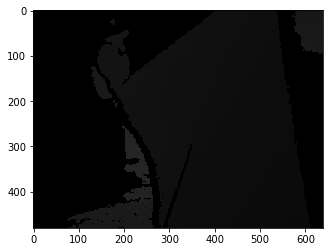

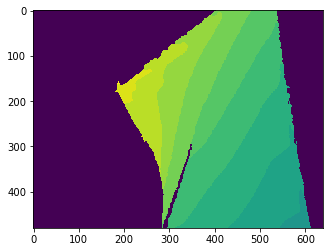

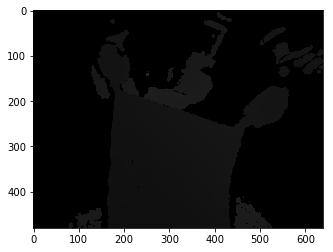

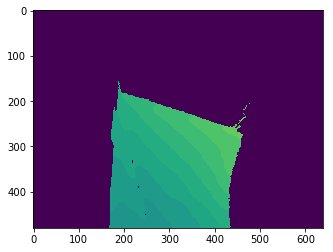

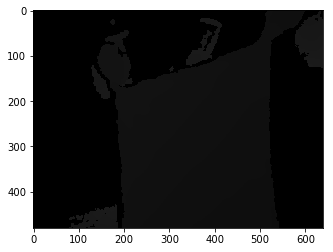

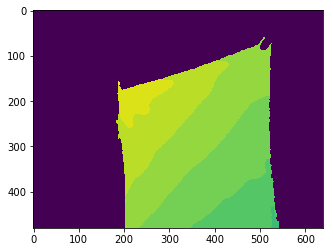

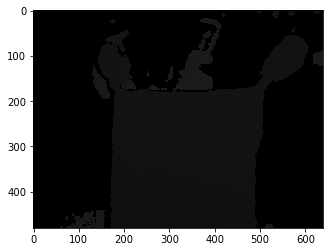

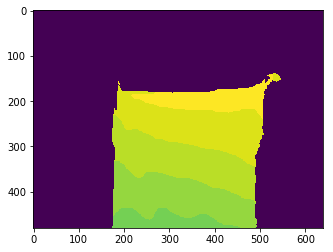

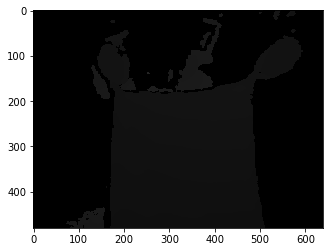

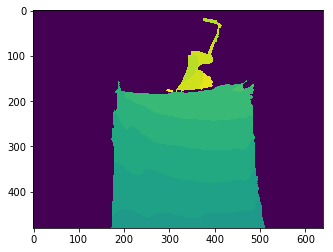

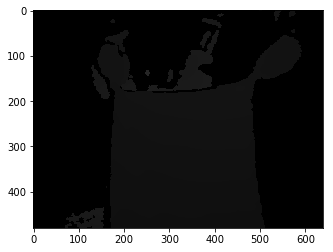

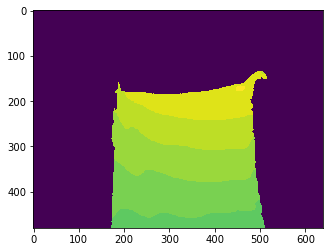

In [6]:
i = 1
def get_fg(img):
    markers = np.uint8(np.zeros((480,640)))
    markers[420:, 300:360] =1
    # set background as 2
    markers[:,0:20] = 2
    markers[:,-20:] = 2
    #markers[0:20,:] = 2
    markers_rgb = markers.astype(np.int32)
    markers_rgb = cv2.watershed(img,markers_rgb)
    fg = np.uint8(markers_rgb == 1)
    return fg

def mk(s):#morph kernel
    return np.ones((s,s),np.uint8)

def shrink(fg):
    shrink_fg = cv2.erode(fg, mk(15), iterations = 2)
    return shrink_fg

for i in range(0,len(depthlist),100):
    depth = cv2.imread(depthlist[i],cv2.)
    plt.imshow(depth), plt.show()
    rgb = cv2.imread(rgblist[i])
    fg = get_fg(rgb)
    #fg = shrink(fg)
    gray = cv2.bitwise_and(depth,depth,mask = fg)
    plt.imshow(gray)
    plt.show()
    

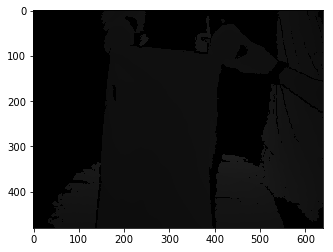

768 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 217, 1077, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1266, 4412, 4457, 5940, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1803, 6122, 7335, 7327, 6875, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 120, 2890, 7823, 7893, 7731, 7306, 6955, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2712, 7137, 7850, 8178, 7755, 7340, 6942, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 6944, 9241, 8345, 8227, 7778, 7120, 6061, 2419, 1535, 322, 729, 305, 0, 0, 0, 0, 0, 155, 630, 1110, 1597, 1960, 2270, 3704, 5727, 5365, 5168, 4640, 4607, 4277, 4717, 6709, 6673, 5727, 6401, 5199, 3194, 3986, 4679, 4461, 4864, 5777, 5857, 5777, 5709, 5650, 5600, 5600, 5600, 5600, 5570, 5321, 5200, 5200, 5200, 6456, 6703, 6400, 6400, 6341, 6018, 6312, 6178, 5430, 4910, 5970, 6000, 6000, 6000, 5998, 5815, 5600, 5600, 5600, 5600, 5550, 5

In [35]:
def gabor_feat(img, num_theta = 4, show_fg=False,show_step=False):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    fg = get_fg(img)
    shrink_fg = cv2.erode(fg, mk(15), iterations = 2)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_and(gray, gray, mask = fg)
    if show_fg:
        plt.imshow(gray,cmap='gray')
        plt.show()
    
    ks = 101 # kernel size    
    avg = np.zeros(gray.shape)
    count = 0
    
    rows, cols = gray.shape
    grid = 80
    
    hist = []
    for i in range(num_theta):
        g_kernel1 = cv2.getGaborKernel((ks, ks), sigma = 6.0, theta = i*np.pi/num_theta, lambd = 10.0, gamma=0.5, psi=0, ktype=cv2.CV_32F)
        filtered = cv2.filter2D(gray, cv2.CV_8UC3, g_kernel1)
        
        for col in np.arange(0, cols, grid):
            for row in np.arange(0, rows, grid):
                block = filtered[row:row+grid,col:col+grid]
                val =  np.sum(block)
                hist.append(val)
        
        
        avg = avg + filtered
        if show_step:
            plt.imshow(filtered)
            plt.show()
    
    avg = avg/num_theta
    return avg, hist

def grid_feat(img):
    hist = []
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rows, cols = gray.shape
    grid = 20
    for col in np.arange(0, cols, grid):
        for row in np.arange(0, rows, grid):
            block = gray[row:row+grid,col:col+grid]
            val =  np.sum(block)
            hist.append(val)
    return hist


i = 900
depth = cv2.imread(depthlist[i])
plt.imshow(depth),plt.show()
hist = grid_feat(depth)
print len(hist),hist, 480*640/40/40

In [41]:
# build up the dataset
feat = np.array([])
for i in range(len(rgblist)):
    depth = cv2.imread(depthlist[i])
    hist = grid_feat(depth)
    hist = np.array(hist)
    feat = np.vstack((feat,hist)) if feat.size else hist
    print feat.shape

# find the edges
data = np.load('data.npz')
vel = data['vel']
pos = data['pos']
print feat.shape
print pos.shape
print vel.shape
np.savez('data2_depth_grid',pos=pos,vel=vel,feat=feat)

(768,)
(2, 768)
(3, 768)
(4, 768)
(5, 768)
(6, 768)
(7, 768)
(8, 768)
(9, 768)
(10, 768)
(11, 768)
(12, 768)
(13, 768)
(14, 768)
(15, 768)
(16, 768)
(17, 768)
(18, 768)
(19, 768)
(20, 768)
(21, 768)
(22, 768)
(23, 768)
(24, 768)
(25, 768)
(26, 768)
(27, 768)
(28, 768)
(29, 768)
(30, 768)
(31, 768)
(32, 768)
(33, 768)
(34, 768)
(35, 768)
(36, 768)
(37, 768)
(38, 768)
(39, 768)
(40, 768)
(41, 768)
(42, 768)
(43, 768)
(44, 768)
(45, 768)
(46, 768)
(47, 768)
(48, 768)
(49, 768)
(50, 768)
(51, 768)
(52, 768)
(53, 768)
(54, 768)
(55, 768)
(56, 768)
(57, 768)
(58, 768)
(59, 768)
(60, 768)
(61, 768)
(62, 768)
(63, 768)
(64, 768)
(65, 768)
(66, 768)
(67, 768)
(68, 768)
(69, 768)
(70, 768)
(71, 768)
(72, 768)
(73, 768)
(74, 768)
(75, 768)
(76, 768)
(77, 768)
(78, 768)
(79, 768)
(80, 768)
(81, 768)
(82, 768)
(83, 768)
(84, 768)
(85, 768)
(86, 768)
(87, 768)
(88, 768)
(89, 768)
(90, 768)
(91, 768)
(92, 768)
(93, 768)
(94, 768)
(95, 768)
(96, 768)
(97, 768)
(98, 768)
(99, 768)
(100, 768)
(101, 768)

(766, 768)
(767, 768)
(768, 768)
(769, 768)
(770, 768)
(771, 768)
(772, 768)
(773, 768)
(774, 768)
(775, 768)
(776, 768)
(777, 768)
(778, 768)
(779, 768)
(780, 768)
(781, 768)
(782, 768)
(783, 768)
(784, 768)
(785, 768)
(786, 768)
(787, 768)
(788, 768)
(789, 768)
(790, 768)
(791, 768)
(792, 768)
(793, 768)
(794, 768)
(795, 768)
(796, 768)
(797, 768)
(798, 768)
(799, 768)
(800, 768)
(801, 768)
(802, 768)
(803, 768)
(804, 768)
(805, 768)
(806, 768)
(807, 768)
(808, 768)
(809, 768)
(810, 768)
(811, 768)
(812, 768)
(813, 768)
(814, 768)
(815, 768)
(816, 768)
(817, 768)
(818, 768)
(819, 768)
(820, 768)
(821, 768)
(822, 768)
(823, 768)
(824, 768)
(825, 768)
(826, 768)
(827, 768)
(828, 768)
(829, 768)
(830, 768)
(831, 768)
(832, 768)
(833, 768)
(834, 768)
(835, 768)
(836, 768)
(837, 768)
(838, 768)
(839, 768)
(840, 768)
(841, 768)
(842, 768)
(843, 768)
(844, 768)
(845, 768)
(846, 768)
(847, 768)
(848, 768)
(849, 768)
(850, 768)
(851, 768)
(852, 768)
(853, 768)
(854, 768)
(855, 768)
(856, 768)

(1479, 768)
(1480, 768)
(1481, 768)
(1482, 768)
(1483, 768)
(1484, 768)
(1485, 768)
(1486, 768)
(1487, 768)
(1488, 768)
(1489, 768)
(1490, 768)
(1491, 768)
(1492, 768)
(1493, 768)
(1494, 768)
(1495, 768)
(1496, 768)
(1497, 768)
(1498, 768)
(1499, 768)
(1500, 768)
(1501, 768)
(1502, 768)
(1503, 768)
(1504, 768)
(1505, 768)
(1506, 768)
(1507, 768)
(1508, 768)
(1509, 768)
(1510, 768)
(1511, 768)
(1512, 768)
(1513, 768)
(1514, 768)
(1515, 768)
(1516, 768)
(1517, 768)
(1518, 768)
(1519, 768)
(1520, 768)
(1521, 768)
(1522, 768)
(1523, 768)
(1524, 768)
(1525, 768)
(1526, 768)
(1527, 768)
(1528, 768)
(1529, 768)
(1530, 768)
(1531, 768)
(1532, 768)
(1533, 768)
(1534, 768)
(1535, 768)
(1536, 768)
(1537, 768)
(1538, 768)
(1539, 768)
(1540, 768)
(1541, 768)
(1542, 768)
(1543, 768)
(1544, 768)
(1545, 768)
(1546, 768)
(1547, 768)
(1548, 768)
(1549, 768)
(1550, 768)
(1551, 768)
(1552, 768)
(1553, 768)
(1554, 768)
(1555, 768)
(1556, 768)
(1557, 768)
(1558, 768)
(1559, 768)
(1560, 768)
(1561, 768)
(156